# Curve Fitting $Y(A,TKE)$ with scipy - Improved and Modified for ONLY U-235

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import pylab as pl
%matplotlib inline

In [2]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


In [3]:
def gauss(x,mu,sigma,w):
    return w/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,w1,mu2,sigma2,w2):
    return gauss(x,mu1,sigma1,w1)+gauss(x,mu2,sigma2,w2)

In [4]:
# functions to gather data

# experimental data range (inclusive)
# A :     [61 180]    -- 120
# TKE :   [111 230]   -- 120

# fit (s1, s2, sl, sum) range (inclusive)
# A :     [0 255]     -- 256
# TKE :   [111 238]   -- 128

# I am using experimental data range as it is smaller and will tighten the data window (avoid 0's)

# easy one
def get_exp_data():
    f=open(os.path.join(os.getcwd(),'tkm0.5_exp.mtx'),"r")
    lines=f.readlines()
    YATKE_exp=[]
    for x in lines:
        x = x.split()
        for y in range(len(x)):
            if len(x) != 0:
                YATKE_exp.append(x[y])
    f.close()
    # eliminate header
    
    # change strings ',' to '.'
    for i in range(len(YATKE_exp)): 
        YATKE_exp[i] = YATKE_exp[i].replace(',', '.')
    
    for i in range(5): YATKE_exp.pop(0)
        
    #convert from strings to floats
    YATKE_exp = list(map(float, YATKE_exp))
    #norm
    total_sum = sum(YATKE_exp)
    YATKE_exp = np.asarray([float(i)/total_sum for i in YATKE_exp])
    
    return YATKE_exp



# hard one
def get_modal_data(instr):
    f=open(os.path.join(os.getcwd(),'tkm0.5-' + instr +'.dat'),"r")
    lines=f.readlines()
    YATKE_mode=[]
    for x in lines:
        x = x.split()
        for y in range(len(x)):
            if len(x) != 0:
                YATKE_mode.append(x[y])
    f.close()
    
    # eliminate header
    for i in range(5): YATKE_mode.pop(0)
        
    # shave off unnecessary data
    # first the excess TKE values
    for i in range(256): 
        for j in range(8): YATKE_mode.pop(120 * (i+1))
    
    # shave off A = 0 - 60
    for i in range(61 * 120): YATKE_mode.pop(0)
        
    #shave off A = 181 - 255
    for i in range(75 * 120): YATKE_mode.pop(120*120)
        
    #convert from strings to floats
    YATKE_mode = list(map(float, YATKE_mode))
    #norm
    total_sum = sum(YATKE_mode)
    YATKE_mode = np.asarray([float(i)/total_sum for i in YATKE_mode])
    
    return YATKE_mode

def rearrange(YATKE):
    return np.transpose(np.asarray(YATKE).reshape(120, 120))

def YATKEplot(YATKE):
    fig, axes = pl.subplots(1, 1, figsize=(15, 10))
    c1 = plt.imshow(YATKE, extent=[61,180, 111,230], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.colorbar(fraction=0.03, pad=0.04)

0.00187924458089


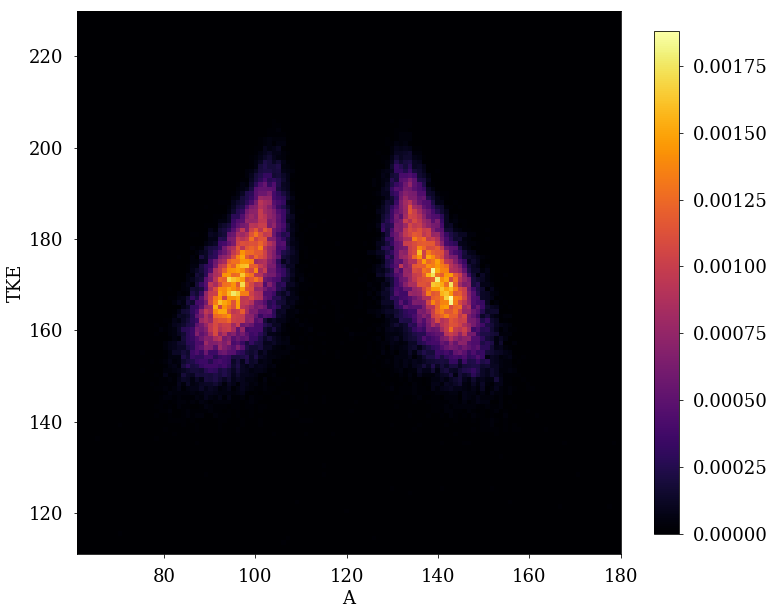

In [5]:
YATKE_exp = get_exp_data()
YATKE_s1 = get_modal_data('s1')
YATKE_s2 = get_modal_data('s2')
YATKE_sl = get_modal_data('sl')
YATKE_sum = get_modal_data('sum')

YATKEplot((YATKE_exp.reshape(120,120)))

print(max(YATKE_exp))

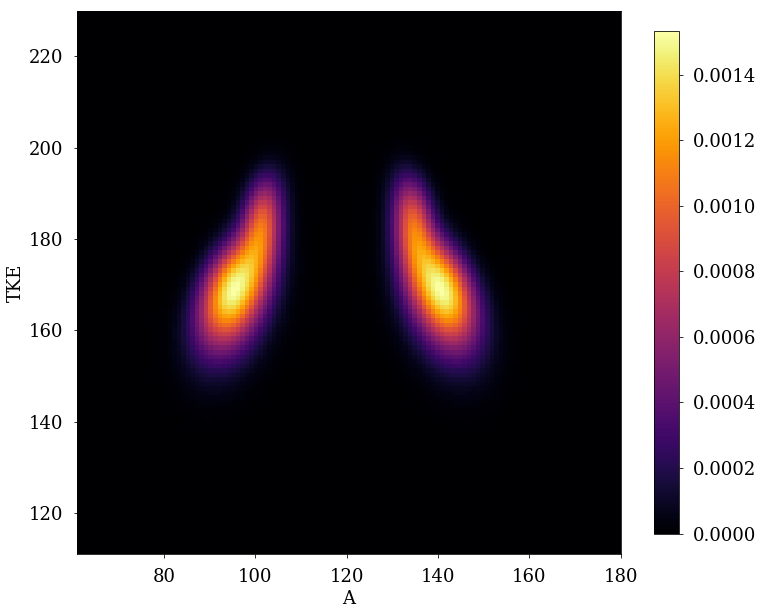

In [6]:
YATKEplot(rearrange(YATKE_sum))

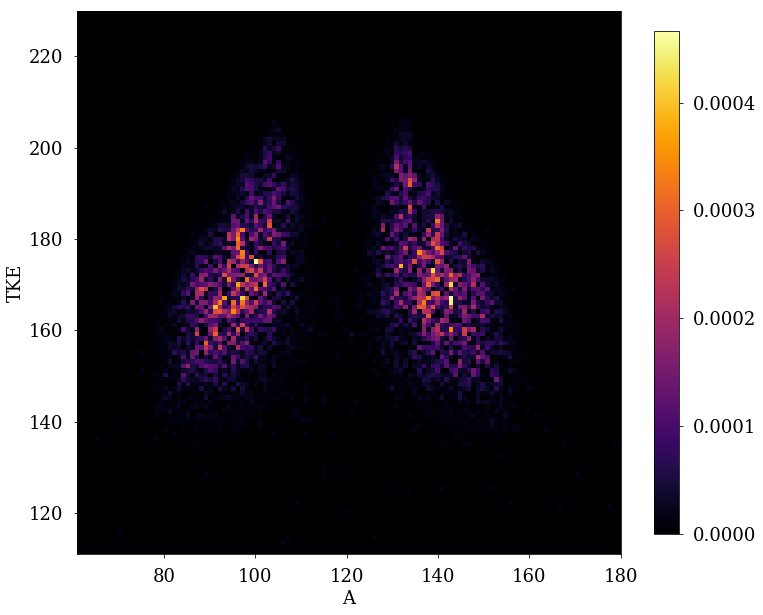

In [7]:
YATKEplot(np.abs((YATKE_exp.reshape(120,120)) - rearrange(YATKE_sum)))

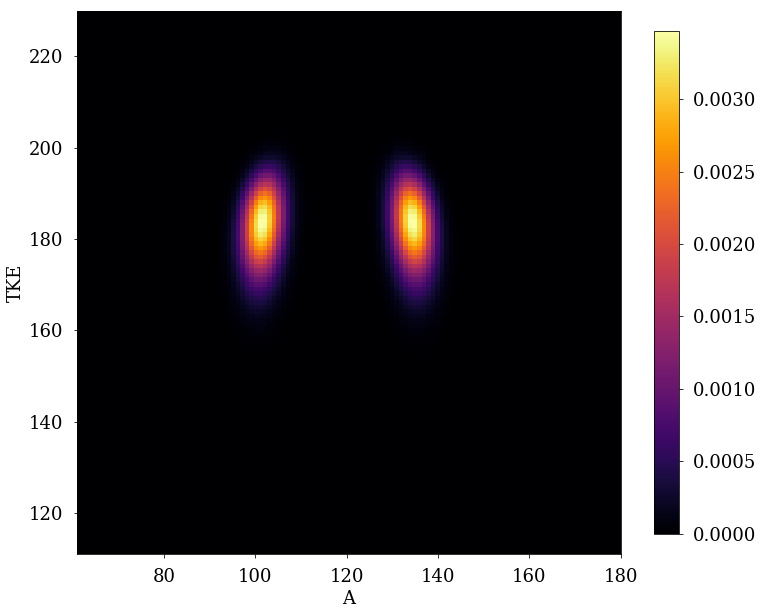

In [8]:
YATKEplot(rearrange(YATKE_s1))

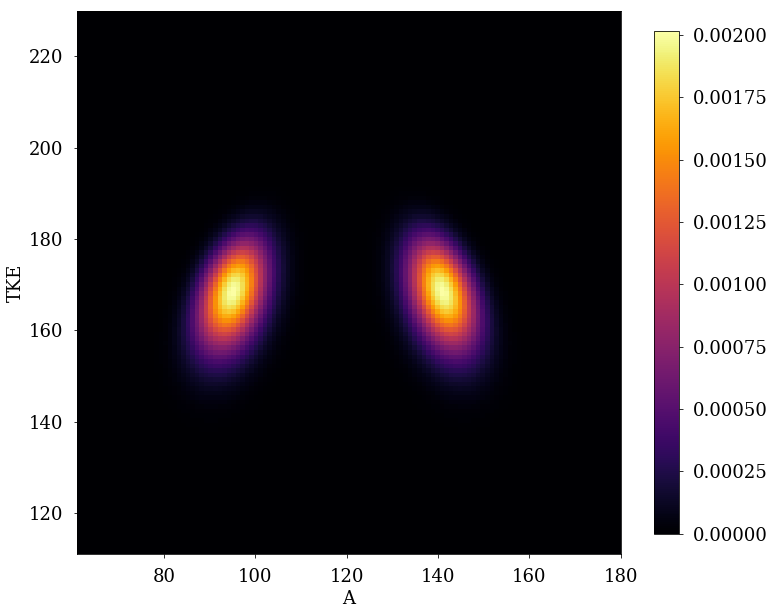

In [9]:
YATKEplot(rearrange(YATKE_s2))

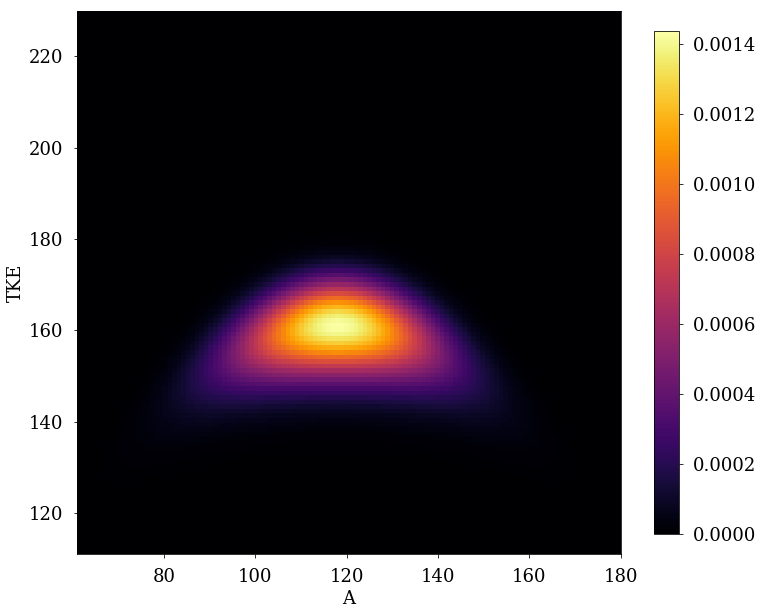

In [10]:
YATKEplot(rearrange(YATKE_sl))

In [11]:
def get_TKEA(YATKE, selection = 0):
    
    A = np.linspace(61,180,120)
    TKE = np.linspace(111,230, 120)
    
    TKEA = np.zeros(len(A))
    varTKEA = np.zeros(len(A))
    
    for i in range(len(A)):
        varTKEA[i] = np.inf
        if sum(YATKE[:,i]) != 0 :
            TKEA[i] = sum(np.multiply(TKE , YATKE[:,i]/sum(YATKE[:,i])))
            varTKEA[i] = sum(np.multiply(np.square(TKE) , YATKE[:,i]/sum(YATKE[:,i]))) - np.square(TKEA[i])
        
    if (selection == 0):
        return TKEA #return TKE(A) -- default
    if (selection == 1):
        return np.sqrt(varTKEA) #return sig

In [12]:
TKEA_exp         = get_TKEA(YATKE_exp.reshape(120,120))
sigTKEA_exp      = get_TKEA(YATKE_exp.reshape(120,120), 1)

TKEA_s1         = get_TKEA(rearrange(YATKE_s1))
sigTKEA_s1      = get_TKEA(rearrange(YATKE_s1), 1)

TKEA_s2         = get_TKEA(rearrange(YATKE_s2))
sigTKEA_s2      = get_TKEA(rearrange(YATKE_s2), 1)

TKEA_sl         = get_TKEA(rearrange(YATKE_sl))
sigTKEA_sl      = get_TKEA(rearrange(YATKE_sl), 1)

TKEA_sum         = get_TKEA(rearrange(YATKE_sum))
sigTKEA_sum      = get_TKEA(rearrange(YATKE_sum), 1)

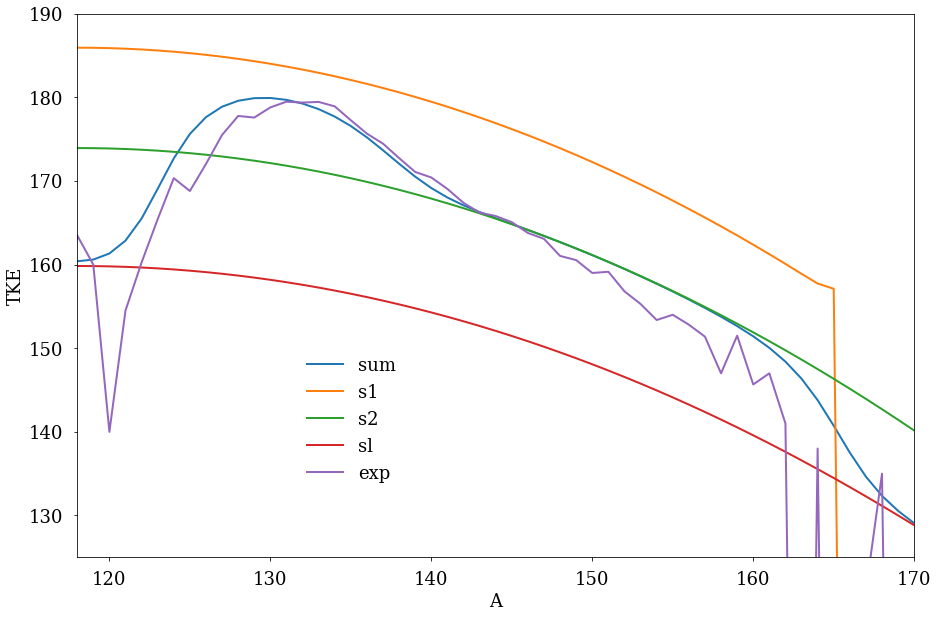

In [13]:
A = np.linspace(61,180,120)
TKE = np.linspace(111,230, 120)

fig, axes = pl.subplots(1, 1, figsize=(15, 10))
plt.plot(A, TKEA_sum, label = 'sum')
plt.plot(A, TKEA_s1, label = 's1')
plt.plot(A, TKEA_s2, label = 's2')
plt.plot(A, TKEA_sl, label = 'sl')
plt.plot(A, TKEA_exp, label = 'exp')

lg = plt.legend(numpoints=1,fontsize=18, bbox_to_anchor=(0.4, 0.4))
lg.draw_frame(False)

plt.xlim(118,170)
plt.ylim(125,190)
plt.ylabel('TKE')
plt.xlabel('A')

S1 Fit:  [ -1.33536307e-02   3.15145695e+00  -3.19444025e-05]
S2 Fit:  [ -1.24917401e-02   2.94805077e+00  -1.59558001e-05]
SL Fit:  [ -1.14789079e-02   2.70902324e+00   1.27815250e-03]


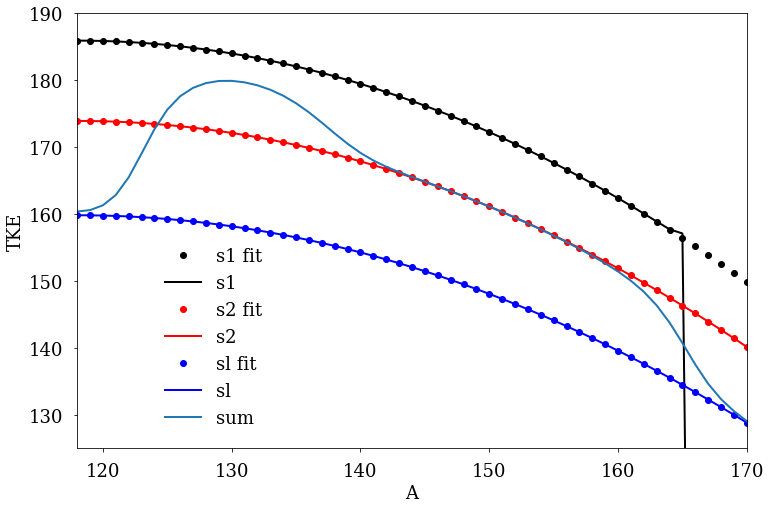

In [14]:
# fit the second order polynomials

fig, axScatter = plt.subplots(figsize=(12,8))

fits1 = np.polyfit(A[20:100],TKEA_s1[20:100],2)
print ('S1 Fit: ',fits1)
polyfitS1 = np.poly1d(fits1)
axScatter.plot(A,polyfitS1(A),'ko', label = 's1 fit')
plt.plot(A, TKEA_s1, 'k-', label = 's1')

fits2 = np.polyfit(A[20:100],TKEA_s2[20:100],2)
print ('S2 Fit: ',fits2)
polyfitS2 = np.poly1d(fits2)
axScatter.plot(A,polyfitS2(A),'ro', label = 's2 fit')
plt.plot(A, TKEA_s2, 'r-', label = 's2')

fitsl = np.polyfit(A[20:100],TKEA_sl[20:100],2)
print ('SL Fit: ', fitsl)
polyfitSl = np.poly1d(fitsl)
axScatter.plot(A,polyfitSl(A),'bo', label = 'sl fit')
plt.plot(A, TKEA_sl, 'b-', label = 'sl')

plt.plot(A, TKEA_sum, label = 'sum')

lg = plt.legend(numpoints=1,fontsize=18, bbox_to_anchor=(0.3, 0.5))
lg.draw_frame(False)

plt.xlim(118,170)
plt.ylim(125,190)
plt.ylabel('TKE')
plt.xlabel('A')

In [15]:
# model dependent on polynomial fits for TKE modes
def YATKE_poly(tuple_in, A_bar0,A_bar1,A_bar2, sig_a0,sig_a1,sig_a2, w0,w1, alpha0,alpha1,alpha2,
               beta0,beta1,beta2, gamma0,gamma1,gamma2):
    
    #unpack the tuple
    A, TKE = tuple_in
    
    # due to pure symmetry of the pre-fission distribution of fragment mass: Y(A), we can assume
    A_bar_S1_L = 236. - A_bar0
    A_bar_S2_L = 236. - A_bar1
    
    # need the variances
    sigTKEA_S1 = get_TKEA(rearrange(YATKE_s1), 1)
    sigTKEA_S2 = get_TKEA(rearrange(YATKE_s2), 1)
    sigTKEA_SL = get_TKEA(rearrange(YATKE_sl), 1)
    sigTKEA_sum = get_TKEA(rearrange(YATKE_sum), 1)
    
    Y = [] # yield list that will be returned
    
    for i in range(len(A)):
        for j in range(len(TKE)):
            #order light S1, light S2, SL, heavy S1, heavy S2, TKE
            Y.append(bimodal(A[i], A_bar0, sig_a0, w0, A_bar_S1_L, sig_a0, w0) * \
                     gauss(TKE[j], alpha0 * A[i]**2 + beta0* A[i] + gamma0 , sigTKEA_S1[i], w0) + \
                    bimodal(A[i], A_bar1, sig_a1, w1, A_bar_S1_L, sig_a1, w1) * \
                     gauss(TKE[j], alpha1 * A[i]**2 + beta1* A[i] + gamma1 , sigTKEA_S2[i], w1) + \
                    gauss(A[i], A_bar2, sig_a2, 1. - w0 - w1) * \
                     gauss(TKE[j], alpha2 * A[i]**2 + beta2* A[i] + gamma2 , sigTKEA_S2[i], 1. - w0 - w1))
    return np.asarray(Y)

In [16]:
# fit YATKE_poly to exp data

A_bar0 = 134.555
A_bar1 = 141.0413
A_bar2 = 118.0

sig_a0 = 3.1326
sig_a1 = 5.1109
sig_a2 = 15.0

w0     = 0.11 
w1     =0.8


guess_poly_exp = (A_bar0,A_bar1,A_bar2, sig_a0,sig_a1,sig_a2, w0,w1, fits1[0],fits2[0],fitsl[0],
               fits1[1],fits2[1],fitsl[1], fits1[2],fits2[2],fitsl[2])

popt_poly_exp, pcov_poly_exp = \
    opt.curve_fit(YATKE_poly, (A, TKE), np.ravel(np.transpose(YATKE_exp.reshape(120,120))), p0=guess_poly_exp,
                 bounds = ([134., 140.,  117.9, 3., 5., 0., 0.,0.,-1.,-1.,-1.,0., 0., 0.,-1.,-1.,-1.],
                         [135.,   142.1, 118.1, 4., 7., 30.,1.,1.,0.,  0., 0.,10.,10.,10.,1., 1., 1.]))

data_fitted_poly_exp = YATKE_poly((A, TKE), *popt_poly_exp)

KeyboardInterrupt: 

In [ ]:
#fit YATKE_poly to sum data

A_bar0 = 134.555
A_bar1 = 141.0413
A_bar2 = 118.0

sig_a0 = 3.1326
sig_a1 = 5.1109
sig_a2 = 15.0

w0     = 0.11 
w1     =0.8


guess_poly_sum = (A_bar0,A_bar1,A_bar2, sig_a0,sig_a1,sig_a2, w0,w1, fits1[0],fits2[0],fitsl[0],
               fits1[1],fits2[1],fitsl[1], fits1[2],fits2[2],fitsl[2])

popt_poly_sum, pcov_poly_sum = opt.curve_fit(YATKE_poly, (A, TKE), YATKE_sum, p0=guess_poly_sum,
                    bounds = ([134., 140.,  117.9, 3., 5., 0., 0.,0.,-1.,-1.,-1.,0., 0., 0.,-1.,-1.,-1.],
                         [135.,   142.1, 118.1, 4., 7., 30.,1.,1.,0.,  0., 0.,10.,10.,10.,1., 1., 1.]))

data_fitted_poly_sum = YATKE_poly((A, TKE), *popt_poly_sum)

In [ ]:
YATKEplot(rearrange(data_fitted_poly_sum))

In [ ]:
print(popt_poly_sum)
print(popt_poly_exp)

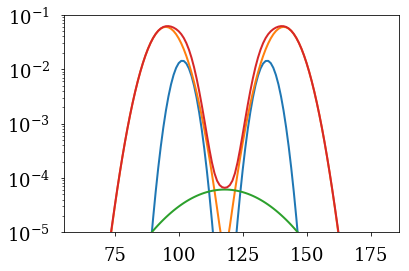

In [40]:
#testing Hambsch equations
A_bars1 = 134.555
A_bars2 = 141.0413
A_barsl = 118.0

sig_as1 = 3.1326
sig_as2 = 5.1109
sig_asl = 15.0

ws1     = 0.113 
ws2     = 0.77
wsl     = 0.0023


YA_s1 = bimodal(A, A_bars1, sig_as1, ws1, 236.-A_bars1, sig_as1, ws1)
YA_s2 = bimodal(A, A_bars2, sig_as2, ws2, 236.-A_bars2, sig_as2, ws2)
YA_sl = gauss(A, A_barsl, sig_asl, wsl)

YA = np.add(np.asarray(YA_s1), np.asarray(YA_s2))
YA = np.add(YA,YA_sl)
plt.semilogy(A,YA_s1)
plt.semilogy(A,YA_s2)
plt.semilogy(A,YA_sl)
plt.semilogy(A,YA)
plt.ylim(10**-5, 10**-1)

# get <TKE>m
def get_meanTKE(YATKE, instr):
    TKE = np.linspace(111,230, 120)
    TKE_mean = 0.0
    TKE_dist = []
    for i in range(len(TKE)):
        TKE_mean += TKE[i] * sum(YATKE[i,:])
        TKE_dist.append(TKE[i] * sum(YATKE[i,:]))
    plt.plot(TKE,TKE_dist, label = instr)
    return TKE_mean



182.148335148
166.950769734
157.164714252
170.810237433


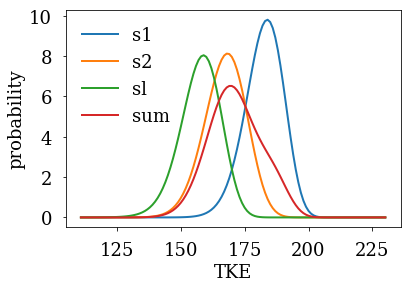

In [42]:
TKEmeans1 = get_meanTKE(rearrange(YATKE_s1), 's1')
print(TKEmeans1)
TKEmeans2 = get_meanTKE(rearrange(YATKE_s2), 's2')
print(TKEmeans2)
TKEmeansl = get_meanTKE(rearrange(YATKE_sl), 'sl')
print(TKEmeansl)
TKEmeansum = get_meanTKE(rearrange(YATKE_sum), 'sum')
print(TKEmeansum)
lg = plt.legend(numpoints=1,fontsize=18)
lg.draw_frame(False)
plt.xlabel('TKE')
plt.ylabel('probability')

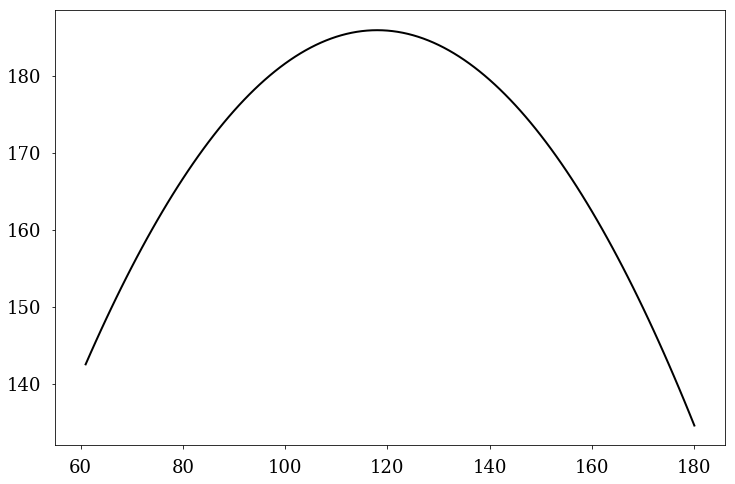

In [44]:
TKEA_s1Ham = []
TKEA_s2Ham = []
TKEA_slHam = []
TKEA_sumHam = []

for i in range(len(A)):
    
    TKEA_s1Ham.append(
        A[i]*(236. - A[i])/(A_bars1 * (236. - A_bars1) - sig_as1**2)*TKEmeans1)
        
    TKEA_s2Ham.append(
        A[i]*(236. - A[i])/(A_bars2 * (236. - A_bars2) - sig_as2**2)*TKEmeans2)
            
    TKEA_slHam.append(
        A[i]*(236. - A[i])/(A_barsl * (236. - A_barsl) - sig_asl**2)*TKEmeansl)

    TKEA_sumHam.append(1./YA[i] * (YA_s1[i] * TKEA_s1Ham[i] + YA_s2[i] * TKEA_s2Ham[i] + YA_sl[i] * TKEA_slHam[i]))

fig, axScatter = plt.subplots(figsize=(12,8))   
plt.plot(A, TKEA_s1Ham, 'k-', label = 's1')
plt.plot(A, TKEA_s2Ham, 'r-', label = 's2')
plt.plot(A, TKEA_slHam, 'b-', label = 'sl')
plt.plot(A, TKEA_sumHam, '-', label = 'sum')
